# Creating a GIS layer for Finnish Health Districts


After exploring the COVID-19 [data set shared by the Helsingin Sanomat datadesk](https://github.com/HS-Datadesk/koronavirus-avoindata) which I spotted on [Twitter](https://twitter.com/EsaMakinen/status/1237007961853173761), I noticed that the boundaries of Finnish health districts (sairaanhoitopiiri) are not openly available anywhere.

This notebook walks you trought the process of creating the health district polygons based on [Statistics Finland municipality polygons and population info](https://www.stat.fi/org/avoindata/paikkatietoaineistot/vaesto_tilastointialueittain.html) and a [list of health care districts by municipality from Kuntaliitto](https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat).

Importing required python packages:

In [1]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt

## Data

- **Finnish municipalities with health district information** as an Excel spreadsheet from here: https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat
    - File `Shp_jäsenkunnat_2020.xls`, sheet `kunnat_shp_2020_ aakkosjärj.`
    - "shp" stands for "sairaanhoitopiiri" (health district in Finnish)
    
*Note: this data set does not include Åland (Ahvenanmaa). Åland municipalities are added in the later step.*

*Note: this info should be also available from a Statistics Finland API(?) in a more standard format. If you know how, let me know!*

In [2]:
data = pd.read_excel("Shp_jäsenkunnat_2020.xls", sheet_name="kunnat_shp_2020_ aakkosjärj.", header=3)

In [3]:
data.dropna(inplace=True)

In [4]:
data.head()

,kunta-\nkoodi,kunta,shp:n koodi,sairaanhoitopiiri,erva-alue,kuntien lkm
1,20.0,Akaa,6.0,Pirkanmaa,TAYS,1.0
2,5.0,Alajärvi,15.0,Etelä-Pohjanmaa,TAYS,2.0
3,9.0,Alavieska,18.0,Pohjois-Pohjanmaa,OYS,3.0
4,10.0,Alavus,15.0,Etelä-Pohjanmaa,TAYS,4.0
5,16.0,Asikkala,7.0,Päijät-Häme,HYKS,5.0


In [5]:
#Check number of rows (16 Åland municipalities are missing)
len(data)

294

The data needs some fixing and cleaning after reading the excel sheet

In [6]:
data.rename(columns={"kunta-\nkoodi":"code", 'sairaanhoitopiiri':'healthCareDistrict'}, inplace=True)
data = data[['code','healthCareDistrict']]

In [7]:
# Truncate and convert to character string
data["code"] = data["code"].astype(int).astype('str')

# Add missing zeros to municipality codes
data["code"] = data["code"].apply(lambda x: "00" + x if len(x)==1 else x)
data["code"] = data["code"].apply(lambda x: "0" + x if len(x)==2 else x)

In [8]:
data.head()

,code,healthCareDistrict
1,020,Pirkanmaa
2,005,Etelä-Pohjanmaa
3,009,Pohjois-Pohjanmaa
4,010,Etelä-Pohjanmaa
5,016,Päijät-Häme


- **Municipality polygons** from Statistics Finland web feature service: https://www.stat.fi/org/avoindata/paikkatietoaineistot/kuntapohjaiset_tilastointialueet.html
    - wfs: http://geo.stat.fi/geoserver/tilastointialueet/wfs?
    - feature: `tilastointialueet:kunta1000k` (most recent information about municipality polygons)





In [9]:
# For available features, see http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetCapabilities
url = "http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetFeature&typename=tilastointialueet:kunta1000k&outputformat=JSON"
geodata = gpd.read_file(url)

In [10]:
# Check length (there are 310 municipalities in Finland in 2020)
len(geodata)

310

In [11]:
#Select and rename columns
geodata = geodata[['kunta', 'geometry']]
geodata.rename(columns={'kunta':'code'}, inplace=True)
geodata.head()

,code,geometry
0,005,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,009,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,010,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,016,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,018,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


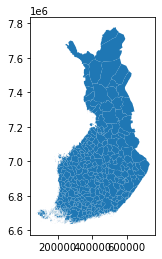

In [12]:
geodata.plot()

- **Population count for each municipality** from Statistics Finland: https://www.stat.fi/org/avoindata/paikkatietoaineistot/vaesto_tilastointialueittain.html

    - WFS: http://geo.stat.fi/geoserver/vaestoalue/wfs 
    - Feature `kunta_vaki2018`: column `vaesto`
    - Latest population data currently available here is from 31.12.2018 with 2019 municipality borders.
    - Note: Valtimo merged with Nurmes in 2020. Belongs to Pohjois-Karjala health care district.
    - *This layer also contains geometries, but I will only use the population info from this layer and join that info to the more recent municipality polygons.*

In [13]:
# For available features, see http://geo.stat.fi/geoserver/vaestoalue/wfs?request=GetCapabilities
url = "http://geo.stat.fi/geoserver/vaestoalue/wfs?request=GetFeature&typename=vaestoalue:kunta_vaki2018&outputformat=JSON"
pop = gpd.read_file(url)

In [14]:
#Select and rename columns
pop = pop[["kunta", "name", "vaesto", "geometry"]]
pop.rename(columns={'kunta':'code', 'vaesto':'population_31_12_2018'}, inplace=True)

In [15]:
pop.head()

,code,name,population_31_12_2018,geometry
0,005,Alajärvi,9700,"MULTIPOLYGON (((348733.187 6959704.551, 343298..."
1,009,Alavieska,2573,"MULTIPOLYGON (((370424.741 7104339.037, 360962..."
2,010,Alavus,11544,"MULTIPOLYGON (((317245.323 6922242.407, 310933..."
3,016,Asikkala,8149,"MULTIPOLYGON (((434407.880 6774122.311, 422536..."
4,018,Askola,4958,"MULTIPOLYGON (((423421.791 6704555.878, 420729..."


In [16]:
# Check length, in 2020, there are 310 Municipalities. 
#This data still contains Valtimo which was merged with Nurmes at the end of 2019
len(pop)

311

In [17]:
# Quick "kuntaliitos"; 
if "Valtimo" in pop["name"].values:
    
    # Update update municipality code and name of Nurmes for Valtimo
    pop.loc[pop["name"]=="Valtimo", "code"] = pop[pop["name"]=="Nurmes"].code.to_numpy()[0]
    pop.loc[pop["name"]=="Valtimo", "name"] = pop[pop["name"]=="Nurmes"].name.to_numpy()[0]
    
    # Merge also polygon geometries (not used in the final alyer, but might be useful later)
    temp = pop.dissolve(by="code", aggfunc='sum')
    temp.reset_index(inplace=True)
    
    # Re-join municipality names to the new geometries
    pop = temp.merge(pop[["code", "name"]].drop_duplicates(), on="code", how="left")

In [18]:
pop.head()

,code,geometry,population_31_12_2018,name
0,005,"POLYGON ((348733.187 6959704.551, 343298.204 6...",9700,Alajärvi
1,009,"POLYGON ((370424.741 7104339.037, 360962.992 7...",2573,Alavieska
2,010,"POLYGON ((317245.323 6922242.407, 310933.466 6...",11544,Alavus
3,016,"POLYGON ((434407.880 6774122.311, 422536.607 6...",8149,Asikkala
4,018,"POLYGON ((423421.791 6704555.878, 420729.970 6...",4958,Askola


In [19]:
len(pop)

310

The population data comes also with municipality polygons. 

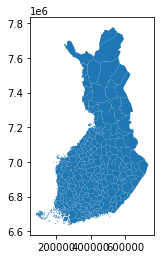

In [20]:
pop.plot()

However, I will return to using the 1000k polygons read in earlier (they are more precise and current).

In [21]:
# Joining population info to the more precise municipality polygons:
geodata = geodata.merge(pop[["code", "name", "population_31_12_2018"]], on="code")

## Join Health district info to the municipality polygons

In [22]:
geodata = geodata.merge(data, on="code", how="left")

In [23]:
geodata.head()

,code,geometry,name,population_31_12_2018,healthCareDistrict
0,005,"POLYGON ((366787.924 7001300.583, 364487.590 6...",Alajärvi,9700,Etelä-Pohjanmaa
1,009,"POLYGON ((382543.364 7120022.976, 382899.505 7...",Alavieska,2573,Pohjois-Pohjanmaa
2,010,"POLYGON ((343298.204 6961570.195, 343831.847 6...",Alavus,11544,Etelä-Pohjanmaa
3,016,"POLYGON ((436139.680 6798279.085, 435714.468 6...",Asikkala,8149,Päijät-Häme
4,018,"POLYGON ((426631.036 6720528.076, 428821.749 6...",Askola,4958,HUS


In [24]:
# Municipalities in the Åland island did not have a matching health care district in the data
geodata[geodata.healthCareDistrict.notnull()==False].name

7          Brändö
8          Eckerö
15       Finström
17          Föglö
18           Geta
24     Hammarland
58         Jomala
112      Kumlinge
122         Kökar
135       Lemland
148    Lumparland
154     Mariehamn
237       Saltvik
255      Sottunga
257          Sund
302         Vårdö
Name: name, dtype: object

In [25]:
# Update "Ahvenanmaa" as the health care district for Åland municipalities (16 municipalities in total)
geodata.loc[geodata.healthCareDistrict.notnull()==False,'healthCareDistrict'] = "Ahvenanmaa"

Check the count of municipalities per health care disctrict

In [26]:
geodata.healthCareDistrict.value_counts()

Pohjois-Pohjanmaa    29
Varsinais-Suomi      28
HUS                  24
Pirkanmaa            23
Keski-Suomi          21
Etelä-Pohjanmaa      18
Pohjois-Savo         18
Satakunta            17
Ahvenanmaa           16
Lappi                15
Pohjois-Karjala      13
Vaasa                13
Päijät-Häme          12
Kanta-Häme           11
Keski-Pohjanmaa      10
Etelä-Savo            9
Etelä-Karjala         9
Kainuu                8
Länsi-Pohja           6
Kymenlaakso           6
Itä-Savo              4
Name: healthCareDistrict, dtype: int64

## Create polygons for health care districts 

In [27]:
# Dissolve (=combine) municipality polygon geometries for each health care district
districts = geodata.dissolve(by='healthCareDistrict', aggfunc="sum")

In [28]:
districts.reset_index(inplace=True)

In [29]:
districts

,healthCareDistrict,geometry,population_31_12_2018
0,Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136...",29789
1,Etelä-Karjala,"POLYGON ((595843.841 6772915.996, 592557.900 6...",128756
2,Etelä-Pohjanmaa,"POLYGON ((373036.311 6953044.961, 376149.768 6...",194316
3,Etelä-Savo,"POLYGON ((596327.952 6823806.064, 596718.363 6...",100226
4,HUS,"MULTIPOLYGON (((272609.681 6632304.439, 272418...",1667203
5,Itä-Savo,"POLYGON ((572240.425 6898837.522, 576521.513 6...",41060
6,Kainuu,"POLYGON ((606127.874 7081796.115, 603849.594 7...",73061
7,Kanta-Häme,"POLYGON ((393094.362 6756355.691, 394102.316 6...",171364
8,Keski-Pohjanmaa,"MULTIPOLYGON (((302835.219 7083897.220, 302801...",77689
9,Keski-Suomi,"POLYGON ((439110.805 6852598.036, 439300.113 6...",252676


(40857.339215, 765862.479085, 6575077.820610001, 7833703.7515899995)

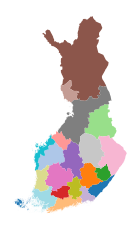

In [30]:
districts.plot(column='healthCareDistrict', scheme="equal_interval",cmap='tab20', k=20)
plt.axis('off')

In [31]:
# Write GeoJSON in original projection
districts.to_file("healthDistrictsEPSG3067.geojson", driver='GeoJSON', encoding='utf-8')

In [32]:
# Re-project to WGS84 and save again
wgs84 = CRS.from_epsg(4326)
districts.to_crs(wgs84).to_file("healthDistrictsEPSG4326.geojson", driver='GeoJSON', encoding='utf-8')

In [33]:
# Write population per health care district to csv
districts[['healthCareDistrict',"population_31_12_2018"]].to_csv("healtCareDistricts_population_31_12_2018.csv", index=False)